# Behavioral vs Neural Timescale Sweep 

Taking both the behavioral and neural timescales to be normally distributed, we run a sweep over different behavioral and neural timescale standard deviations.

## Set up

In [15]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [16]:
from pathlib import Path

sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/timescale_means_sweep_20260102_080735"
)
os.path.exists(sweep_dir)

True

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Grid parameters (from sweep config)
neural_means = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]
behav_means = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]


def format_value(v):
    """Format value for experiment naming - removes .0 from whole numbers."""
    if float(v) == int(v):
        return str(int(v))
    return str(v)


def load_experiment_data(sweep_dir, neural_mean, behav_mean, seed=0):
    """Load training losses and decoding errors for a single experiment."""
    exp_name = (
        f"neural_mean_{format_value(neural_mean)}_behav_mean_{format_value(behav_mean)}"
    )
    exp_path = sweep_dir / exp_name / f"seed_{seed}"

    # Load training losses
    with open(exp_path / "training_losses.json") as f:
        losses = json.load(f)

    # Load decoding errors
    with open(exp_path / "position_decoding_errors.json") as f:
        errors = json.load(f)

    return {
        "epochs": np.array(losses["epochs"]),
        "train_loss": np.array(losses["train_losses_epoch"]),
        "val_loss": np.array(losses["val_losses_epoch"]),
        "decoding_error": np.array(errors["position_errors_epoch"]),
    }


# Load all experiments
data = {}
for nm in neural_means:
    for bm in behav_means:
        data[(nm, bm)] = load_experiment_data(sweep_dir, nm, bm)


# === Plotting functions ===
def plot_grid(
    data,
    neural_means,
    behav_means,
    metric_key,
    ylabel,
    title,
    log_x=False,
    log_y=False,
    figsize=(14, 12),
):
    """
    Create a grid of plots for timescale means sweep.

    Rows: behavioral timescale mean (increasing downward)
    Cols: neural timescale mean (increasing rightward)
    """
    n_rows = len(behav_means)
    n_cols = len(neural_means)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=True)

    for i, bm in enumerate(behav_means):
        for j, nm in enumerate(neural_means):
            ax = axes[i, j]
            d = data[(nm, bm)]

            ax.plot(d["epochs"], d[metric_key], linewidth=1.5)

            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")

            # Title only on top row
            if i == 0:
                ax.set_title(f"τ_n={nm}", fontsize=9)

            # Y-label only on left column
            if j == 0:
                ax.set_ylabel(f"τ_b={bm}\n{ylabel}", fontsize=8)

            # X-label only on bottom row
            if i == len(behav_means) - 1:
                ax.set_xlabel("Epoch", fontsize=8)

            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=7)

    fig.suptitle(title, fontsize=14, y=1.01)
    plt.tight_layout()
    return fig, axes

In [18]:
import torch


def compute_target_entropy(exp_dir: Path, n_grid_points: int = 50):
    """Compute average target entropy over a grid of positions."""
    seed_dir = exp_dir / "seed_0"

    # Load place cell centers
    centers = torch.load(seed_dir / "place_cell_centers_seed0.pt")  # (N_pc, 2)

    # Load config for other params
    with open(seed_dir / "config_seed0.yaml") as f:
        cfg = yaml.safe_load(f)

    rf = cfg["place_cell_rf"]
    arena_size = cfg["arena_size"]
    DoG = cfg["DoG"]
    surround_scale = cfg["surround_scale"]

    # Create grid of positions spanning arena
    R = arena_size / 2
    xs = torch.linspace(-R, R, n_grid_points)
    ys = torch.linspace(-R, R, n_grid_points)
    xx, yy = torch.meshgrid(xs, ys, indexing="ij")
    positions = torch.stack([xx.flatten(), yy.flatten()], dim=-1)  # (N_pos, 2)

    # Compute place cell activations for each position
    # pos: (N_pos, 2), centers: (N_pc, 2)
    d2 = ((positions[:, None, :] - centers[None, :, :]) ** 2).sum(-1)  # (N_pos, N_pc)

    activations = torch.softmax(-d2 / (2 * rf**2), dim=-1)

    if DoG:
        surround = torch.softmax(-d2 / (2 * surround_scale * rf**2), dim=-1)
        activations = activations - surround
        activations = activations - activations.min(dim=-1, keepdim=True).values
        activations = activations / activations.sum(dim=-1, keepdim=True)

    # Compute entropy for each position, then average
    entropy = -(activations * torch.log(activations + 1e-8)).sum(-1)  # (N_pos,)

    return entropy.mean().item()

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml


def load_final_metrics(
    sweep_dir, neural_means, behav_means, seed=0, subtract_entropy=False
):
    """Load final values for all experiments into 2D arrays.

    Args:
        sweep_dir: Path to sweep directory
        neural_means: List of neural timescale mean values
        behav_means: List of behavioral timescale mean values
        seed: Random seed (default 0)
        subtract_entropy: If True, subtract target entropy from losses to get KL divergence

    Returns:
        final_train_loss, final_val_loss, final_decoding_error (as KL if subtract_entropy=True)
    """
    n_neural = len(neural_means)
    n_behav = len(behav_means)

    final_train_loss = np.zeros((n_neural, n_behav))
    final_val_loss = np.zeros((n_neural, n_behav))
    final_decoding_error = np.zeros((n_neural, n_behav))
    target_entropies = np.zeros((n_neural, n_behav))  # For diagnostics

    for i, nm in enumerate(neural_means):
        for j, bm in enumerate(behav_means):
            exp_name = f"neural_mean_{format_value(nm)}_behav_mean_{format_value(bm)}"
            exp_path = sweep_dir / exp_name / f"seed_{seed}"

            with open(exp_path / "training_losses.json") as f:
                losses = json.load(f)
            with open(exp_path / "position_decoding_errors.json") as f:
                errors = json.load(f)

            train_loss = losses["train_losses_epoch"][-1]
            val_loss = losses["val_losses_epoch"][-1]

            if subtract_entropy:
                # Compute target entropy for this experiment
                H = compute_target_entropy(
                    sweep_dir
                    / f"neural_mean_{format_value(nm)}_behav_mean_{format_value(bm)}"
                )
                target_entropies[i, j] = H
                train_loss -= H
                val_loss -= H

            final_train_loss[i, j] = train_loss
            final_val_loss[i, j] = val_loss
            final_decoding_error[i, j] = errors["position_errors_epoch"][-1]

    if subtract_entropy:
        print(
            f"Target entropy range: {target_entropies.min():.4f} - {target_entropies.max():.4f}"
        )

    return final_train_loss, final_val_loss, final_decoding_error


# Load all final metrics
final_train, final_val, final_error = load_final_metrics(
    sweep_dir, neural_means, behav_means, subtract_entropy=True
)


def plot_heatmap(
    matrix,
    neural_means,
    behav_means,
    title,
    cbar_label,
    cmap="viridis",
    figsize=(8, 6),
    annot=True,
    fmt=".3f",
):
    """
    Plot a heatmap with behavioral τ_mean on x-axis and neural τ_mean on y-axis.
    """
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(matrix, cmap=cmap, aspect="auto", origin="lower")

    # Set tick labels
    ax.set_xticks(np.arange(len(behav_means)))
    ax.set_xticklabels([str(b) for b in behav_means])
    ax.set_yticks(np.arange(len(neural_means)))
    ax.set_yticklabels([str(n) for n in neural_means])

    ax.set_xlabel("Behavioral Timescale Mean (s)", fontsize=12)
    ax.set_ylabel("Neural Timescale Mean (s)", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)

    # Annotate cells with values
    if annot:
        for i in range(len(neural_means)):
            for j in range(len(behav_means)):
                text = ax.text(
                    j,
                    i,
                    f"{matrix[i, j]:{fmt}}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="white" if matrix[i, j] < matrix.mean() else "black",
                )

    plt.tight_layout()
    return fig, ax

Target entropy range: 5.0259 - 5.0259


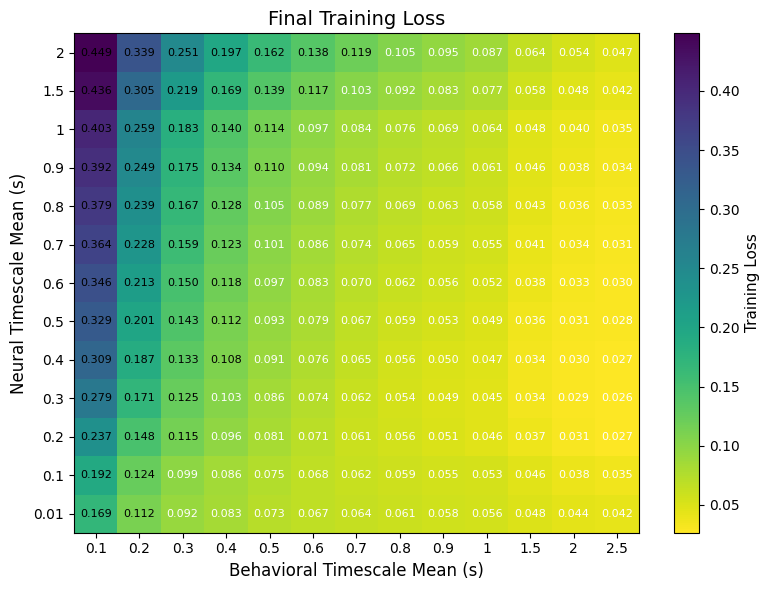

In [20]:
# 1. Final Training Loss
fig1, _ = plot_heatmap(
    final_train,
    neural_means,
    behav_means,
    title="Final Training Loss",
    cbar_label="Training Loss",
    cmap="viridis_r",  # reversed so lower = better = darker
)
plt.show()

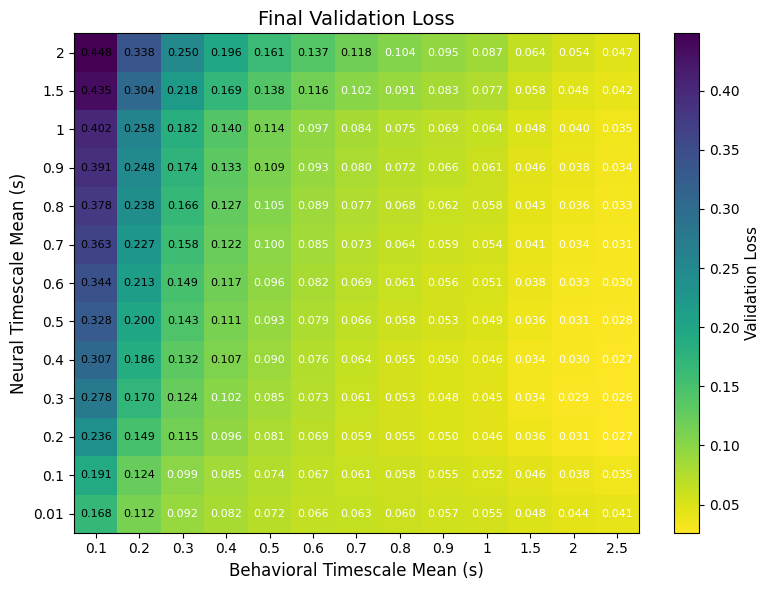

In [ ]:
# 2. Final Validation Loss
fig1, _ = plot_heatmap(
    final_val,
    neural_means,
    behav_means,
    title="Final Validation Loss",
    cbar_label="Validation Loss",
    cmap="viridis_r",  # reversed so lower = better = darker
)
plt.show()

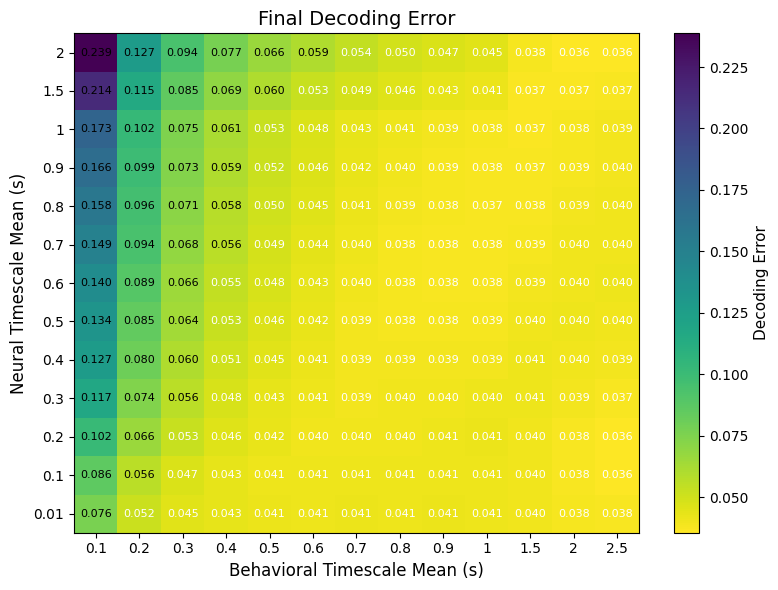

In [30]:
# 3. Final Decoding Error
fig1, _ = plot_heatmap(
    final_error,
    neural_means,
    behav_means,
    title="Final Decoding Error",
    cbar_label="Decoding Error",
    cmap="viridis_r",  # reversed so lower = better = darker
)
plt.show()

## Look at neuron tuning curves

In [21]:
# Cell 1: Load models from the heterogeneity sweep
from timescales.analysis.load_models import load_experiment_sweep
import torch

sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059"
)
device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

print(f"\nLoaded {len(models)} experiments")
print("Available experiments:", list(models.keys())[:5], "...")

Loading 132 experiments with 1 seeds each...
Total models to load: 132
Using Lightning checkpoints

Loading experiment: neural_std_0_behav_std_0
  ✓ Loaded neural_std_0_behav_std_0/seed_0
Loading experiment: neural_std_0_behav_std_0.05
  ✓ Loaded neural_std_0_behav_std_0.05/seed_0
Loading experiment: neural_std_0_behav_std_0.1
  ✓ Loaded neural_std_0_behav_std_0.1/seed_0
Loading experiment: neural_std_0_behav_std_0.15
  ✓ Loaded neural_std_0_behav_std_0.15/seed_0
Loading experiment: neural_std_0_behav_std_0.2
  ✓ Loaded neural_std_0_behav_std_0.2/seed_0
Loading experiment: neural_std_0_behav_std_0.25
  ✓ Loaded neural_std_0_behav_std_0.25/seed_0
Loading experiment: neural_std_0_behav_std_0.3
  ✓ Loaded neural_std_0_behav_std_0.3/seed_0
Loading experiment: neural_std_0_behav_std_0.35
  ✓ Loaded neural_std_0_behav_std_0.35/seed_0
Loading experiment: neural_std_0_behav_std_0.4
  ✓ Loaded neural_std_0_behav_std_0.4/seed_0
Loading experiment: neural_std_0_behav_std_0.45
  ✓ Loaded neural_st

In [22]:
# Select a specific experiment and seed
exp_name = "neural_std_0.1_behav_std_0.1"  # <-- Change this to explore different models
seed = 0

model_data = models[exp_name][seed]
model = model_data["model"]
config = model_data["config"]
place_cell_centers = model_data["place_cell_centers"]

model.eval()
print(f"Selected: {exp_name}, seed {seed}")
print(f"  Neural τ std: {config['timescales_config']['std']}")
print(f"  Behavioral τ std: {config['behavioral_timescale_std']}")

Selected: neural_std_0.1_behav_std_0.1, seed 0
  Neural τ std: 0.1
  Behavioral τ std: 0.1


In [23]:
# Create evaluation datamodule matching this model's config
from timescales.datamodule import PathIntegrationDataModule

eval_datamodule = PathIntegrationDataModule(
    trajectory_type=config["trajectory_type"],
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=config["num_time_steps"],
    arena_size=config["arena_size"],
    behavioral_timescale_mean=config["behavioral_timescale_mean"],
    behavioral_timescale_std=config["behavioral_timescale_std"],
    linear_speed_tau=config["linear_speed_tau"],
    angular_speed_mean=config["angular_speed_mean"],
    angular_speed_std=config["angular_speed_std"],
    angular_speed_tau=config["angular_speed_tau"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    DoG=config["DoG"],
    surround_scale=config["surround_scale"],
    place_cell_layout=config["place_cell_layout"],
    num_trajectories=10000,
    batch_size=1,
    num_workers=1,
    train_val_split=0.0,
)

# Override place cell centers to match training
eval_datamodule.place_cell_centers = place_cell_centers

eval_datamodule.setup()
eval_loader = eval_datamodule.val_dataloader()

print(f"Eval loader ready: {len(eval_loader)} batches")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.100s
  → linear_speed: mean=0.200m/s, std=0.020m/s


Eval loader ready: 10000 batches


In [24]:
# Compute and visualize spatial rate maps
from timescales.analysis.spatial import SpatialAnalyzer

spatial = SpatialAnalyzer(
    model=model,
    device=device,
    model_type="multitimescale",
)

spatial.compute_rate_maps(
    eval_loader=eval_loader,
    arena_size=config["arena_size"],
    bin_size=0.05,
    num_trajectories=4000,
    min_occupancy=10,
    time_lag=0,  # Change for prospective/retrospective analysis
)

Computing concurrent spatial rate maps using 4000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05


Hidden units to analyze: 512
Processed 1/4000 trajectories...
Processed 51/4000 trajectories...
Processed 101/4000 trajectories...
Processed 151/4000 trajectories...
Processed 201/4000 trajectories...
Processed 251/4000 trajectories...
Processed 301/4000 trajectories...
Processed 351/4000 trajectories...
Processed 401/4000 trajectories...
Processed 451/4000 trajectories...
Processed 501/4000 trajectories...
Processed 551/4000 trajectories...
Processed 601/4000 trajectories...
Processed 651/4000 trajectories...
Processed 701/4000 trajectories...
Processed 751/4000 trajectories...
Processed 801/4000 trajectories...
Processed 851/4000 trajectories...
Processed 901/4000 trajectories...
Processed 951/4000 trajectories...
Processed 1001/4000 trajectories...
Processed 1051/4000 trajectories...
Processed 1101/4000 trajectories...
Processed 1151/4000 trajectories...
Processed 1201/4000 trajectories...
Processed 1251/4000 trajectories...
Processed 1301/4000 trajectories...
Processed 1351/4000 tr

Selected 25 random units: [ 10  30  78  84 124 131 153 184 195 204 208 209 222 247 281 289 304 324
 325 352 361 439 495 497 506]


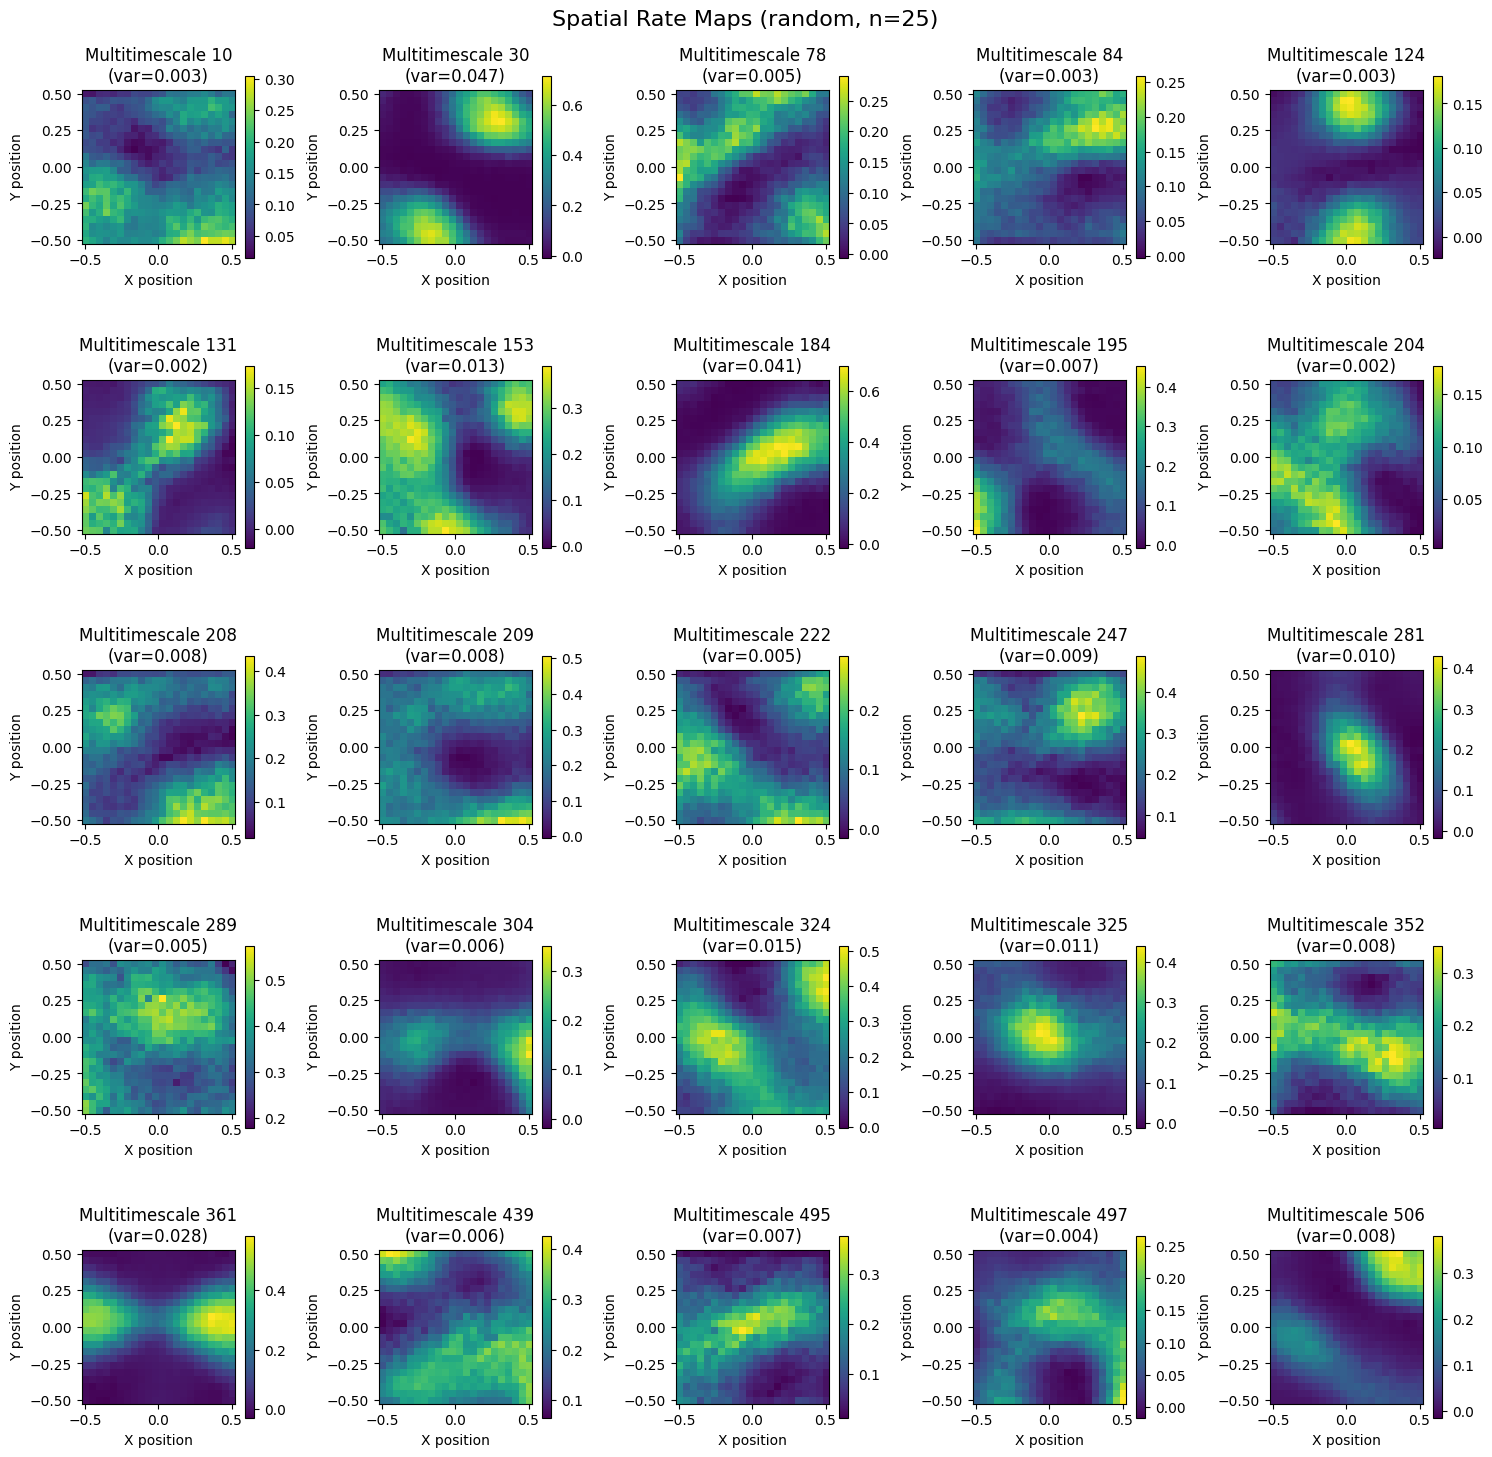

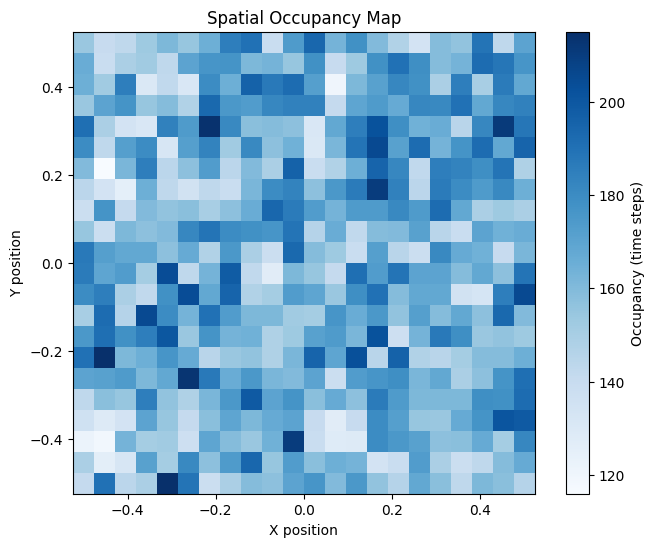


Visualized: neural_std_0.1_behav_std_0.1


In [25]:
# Plot top 25 units by spatial information
spatial.plot_rate_maps(num_units=25, selection_method="random").plot_occupancy_map()

print(f"\nVisualized: {exp_name}")

Computing grid scores for 512 units...


/home/facosta/timescales/timescales/scores.py:130: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


  Processed 50/512 units...
  Processed 100/512 units...
  Processed 150/512 units...
  Processed 200/512 units...
  Processed 250/512 units...
  Processed 300/512 units...
  Processed 350/512 units...
  Processed 400/512 units...
  Processed 450/512 units...
  Processed 500/512 units...
Grid score computation complete!
  Mean 60° score: 0.165 ± 0.440
  Mean 90° score: 0.397 ± 0.553
  Max 60° score: 1.619
  Max 90° score: 1.632


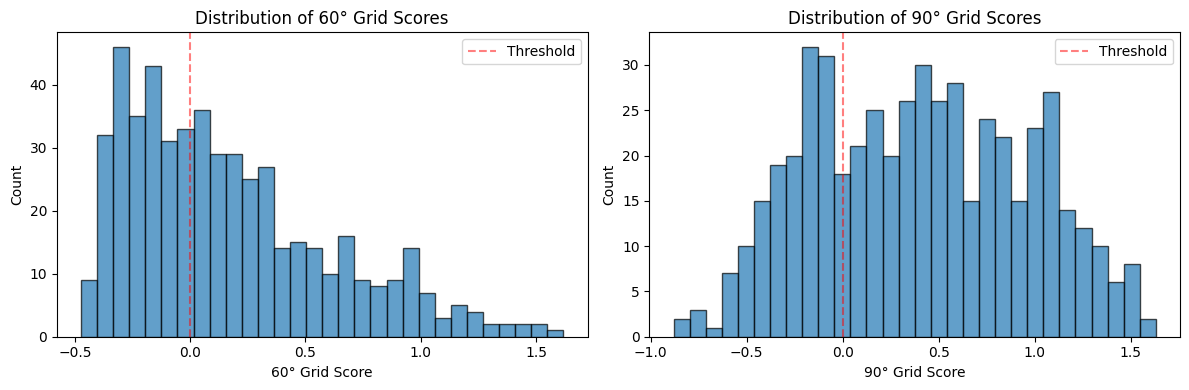

Units with positive 60° grid score: 288
Units with positive 90° grid score: 360


In [26]:
# Compute grid scores
grid_results = spatial.compute_grid_scores(
    mask_parameters=[(0.4, 1.0), (0.5, 1.0), (0.6, 1.0)],  # Try different scales
    min_max=False,
)

# Show distribution of grid scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(grid_results["scores_60"], bins=30, alpha=0.7, edgecolor="black")
axes[0].set_xlabel("60° Grid Score")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of 60° Grid Scores")
axes[0].axvline(0, color="red", linestyle="--", alpha=0.5, label="Threshold")
axes[0].legend()

axes[1].hist(grid_results["scores_90"], bins=30, alpha=0.7, edgecolor="black")
axes[1].set_xlabel("90° Grid Score")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of 90° Grid Scores")
axes[1].axvline(0, color="red", linestyle="--", alpha=0.5, label="Threshold")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"Units with positive 60° grid score: {np.sum(grid_results['scores_60'] > 0)}")
print(f"Units with positive 90° grid score: {np.sum(grid_results['scores_90'] > 0)}")

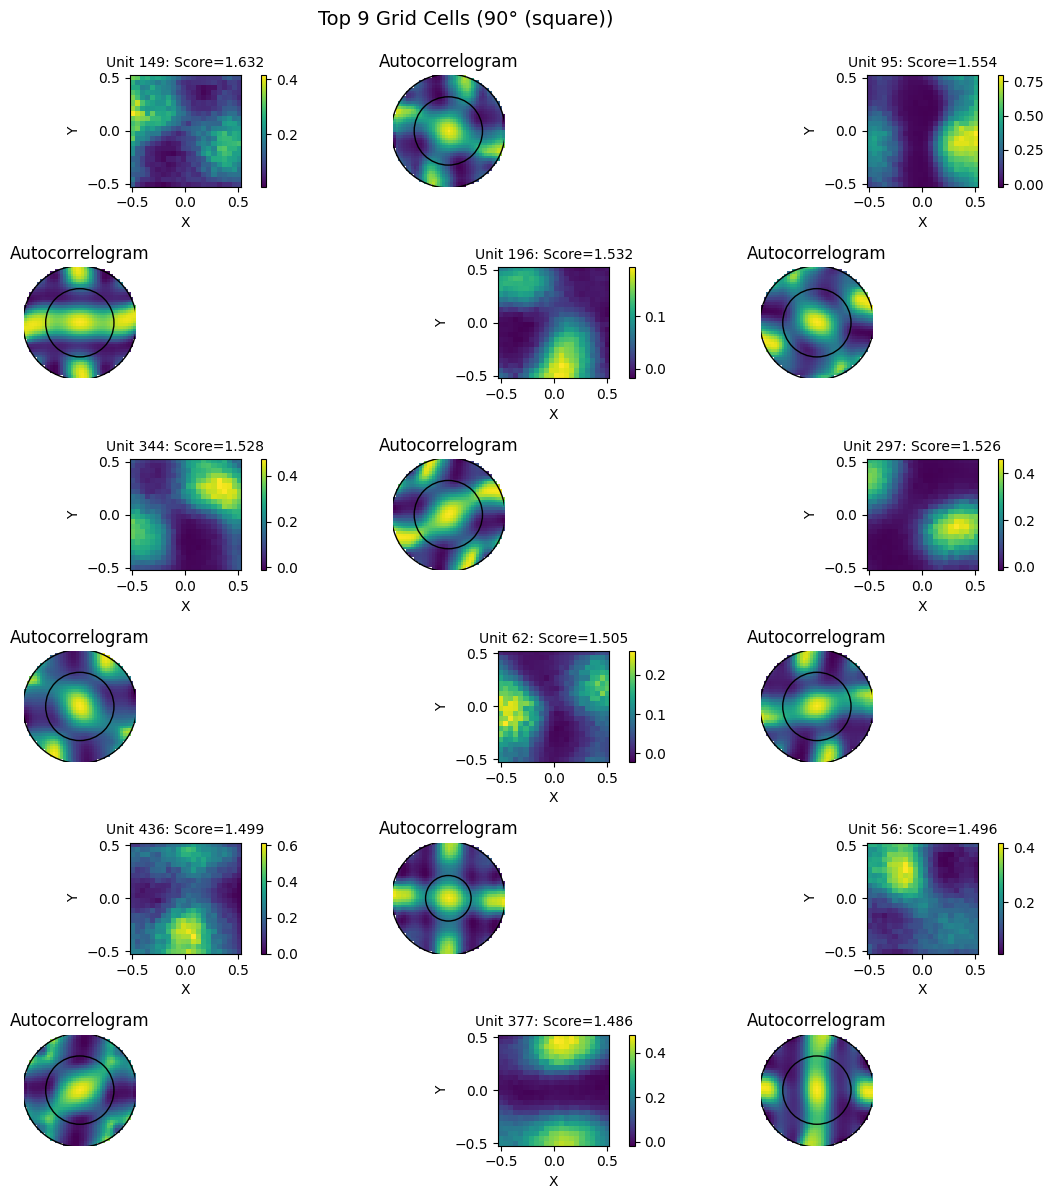

In [27]:
# Visualize top grid cells
spatial.plot_top_grid_cells(num_cells=9, score_type="90")

In [28]:
# Cell: Compute Grid Cell Percentages Across Sweep
import numpy as np
import matplotlib.pyplot as plt
from timescales.analysis.spatial import SpatialAnalyzer
from tqdm.auto import tqdm
import torch

# Parameters
grid_score_threshold = 0.0  # Common threshold: positive grid score
score_type = "60"  # Use 60-degree score for hexagonal grids (can also try '90')
num_trajectories = 2000
bin_size = 0.05

# Grid parameters (should match your sweep)
neural_stds = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
behav_stds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]

# Initialize results array
grid_cell_percentages = np.zeros((len(neural_stds), len(behav_stds)))
grid_cell_counts = np.zeros((len(neural_stds), len(behav_stds)))
total_units = np.zeros((len(neural_stds), len(behav_stds)))

# Loop through all experiments
print(
    f"Computing grid scores across {len(neural_stds)} x {len(behav_stds)} = {len(neural_stds)*len(behav_stds)} experiments"
)
print(f"Using threshold: {grid_score_threshold}, score type: {score_type}°")
print("-" * 80)

for i, ns in enumerate(neural_stds):
    for j, bs in enumerate(behav_stds):
        exp_name = f"neural_std_{ns}_behav_std_{bs}"

        # Check if experiment exists
        if exp_name not in models:
            print(f"Warning: {exp_name} not found in loaded models")
            continue

        # Get model for seed 0 (or loop over seeds if desired)
        seed = 0
        if seed not in models[exp_name]:
            print(f"Warning: seed {seed} not found for {exp_name}")
            continue

        model_data = models[exp_name][seed]
        model = model_data["model"]
        config = model_data["config"]

        print(
            f"[{i*len(behav_stds)+j+1}/{len(neural_stds)*len(behav_stds)}] Processing {exp_name}..."
        )

        try:
            # Initialize spatial analyzer
            spatial = SpatialAnalyzer(
                model=model,
                device=device,
                model_type="multitimescale",
            )

            # Compute rate maps
            spatial.compute_rate_maps(
                eval_loader=eval_loader,  # Make sure eval_loader is defined
                arena_size=config["arena_size"],
                bin_size=bin_size,
                num_trajectories=num_trajectories,
                min_occupancy=10,
                time_lag=0,
            )

            # Compute grid scores
            grid_results = spatial.compute_grid_scores(
                mask_parameters=[(0.4, 1.0), (0.5, 1.0), (0.6, 1.0)], min_max=False
            )

            # Get scores based on type
            if score_type == "60":
                scores = grid_results["scores_60"]
            else:
                scores = grid_results["scores_90"]

            # Count grid cells above threshold
            n_grid_cells = np.sum(scores > grid_score_threshold)
            n_total = len(scores)
            percentage = 100 * n_grid_cells / n_total

            # Store results
            grid_cell_percentages[i, j] = percentage
            grid_cell_counts[i, j] = n_grid_cells
            total_units[i, j] = n_total

            print(f"  → Grid cells: {n_grid_cells}/{n_total} ({percentage:.1f}%)")
            print(
                f"  → Mean score: {np.mean(scores):.3f}, Max score: {np.max(scores):.3f}"
            )

        except Exception as e:
            print(f"  ERROR processing {exp_name}: {e}")
            grid_cell_percentages[i, j] = np.nan

        print()

print("=" * 80)
print("Grid score computation complete!")
print(f"Overall statistics:")
print(f"  Mean grid cell percentage: {np.nanmean(grid_cell_percentages):.1f}%")
print(
    f"  Min: {np.nanmin(grid_cell_percentages):.1f}%, Max: {np.nanmax(grid_cell_percentages):.1f}%"
)

/home/facosta/.cache/pypoetry/virtualenvs/pirnns-yK7ughNc-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing grid scores across 12 x 11 = 132 experiments
Using threshold: 0.0, score type: 60°
--------------------------------------------------------------------------------
[1/132] Processing neural_std_0_behav_std_0...
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 1/2000 trajectories...
Processed 51/2000 trajectories...
Processed 101/2000 trajectories...
Processed 151/2000 trajectories...
Processed 201/2000 trajectories...
Processed 251/2000 trajectories...
Processed 301/2000 trajectories...
Processed 351/2000 trajectories...
Processed 401/2000 trajectories...
Processed 451/2000 trajectories...
Processed 501/2000 trajectories...
Processed 551/2000 trajectories...
Processed 601/2000 trajectories...
Processed 651/2000 trajectories...
Processed 701/2000 trajectories...
Processed 751/2000 trajectories...
Processed 801/2000 trajectories...
Processed 851/2000 trajectories...
Processed 901/200

/home/facosta/timescales/timescales/scores.py:130: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


  Processed 50/512 units...
  Processed 100/512 units...
  Processed 150/512 units...
  Processed 200/512 units...
  Processed 250/512 units...
  Processed 300/512 units...
  Processed 350/512 units...
  Processed 400/512 units...
  Processed 450/512 units...
  Processed 500/512 units...
Grid score computation complete!
  Mean 60° score: 0.190 ± 0.445
  Mean 90° score: 0.370 ± 0.533
  Max 60° score: 1.523
  Max 90° score: 1.575
  → Grid cells: 307/512 (60.0%)
  → Mean score: 0.190, Max score: 1.523

[2/132] Processing neural_std_0_behav_std_0.05...
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 1/2000 trajectories...
Processed 51/2000 trajectories...
Processed 101/2000 trajectories...
Processed 151/2000 trajectories...
Processed 201/2000 trajectories...
Processed 251/2000 trajectories...
Processed 301/2000 trajectories...
Processed 351/2000 trajectories...
Processed 401/2000 trajectories..

KeyboardInterrupt: 

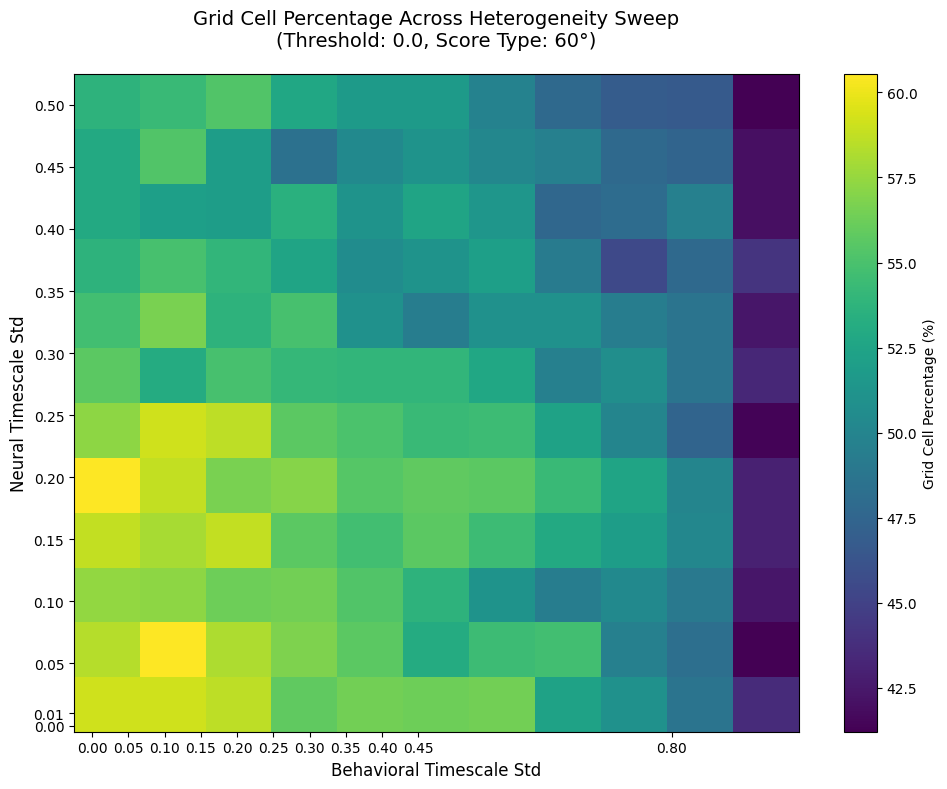

Key observations:
Experiment with highest grid cell %: neural_std=0.01, behav_std=0.05 (60.5%)
Experiment with lowest grid cell %: neural_std=0.01, behav_std=0.8 (41.2%)


In [ ]:
# Cell: Visualize Grid Cell Percentage Heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create heatmap
im = ax.imshow(
    grid_cell_percentages,
    aspect="auto",
    cmap="viridis",  # or try 'RdYlGn', 'plasma', 'hot'
    origin="lower",
    extent=[
        behav_stds[0] - (behav_stds[1] - behav_stds[0]) / 2,
        behav_stds[-1] + (behav_stds[-1] - behav_stds[-2]) / 2,
        neural_stds[0] - (neural_stds[1] - neural_stds[0]) / 2,
        neural_stds[-1] + (neural_stds[-1] - neural_stds[-2]) / 2,
    ],
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label="Grid Cell Percentage (%)")

# Add grid cell percentage values as text
for i, ns in enumerate(neural_stds):
    for j, bs in enumerate(behav_stds):
        percentage = grid_cell_percentages[i, j]
        # if not np.isnan(percentage):
        # Choose text color based on background
        # text_color = "white" if percentage > 50 else "black"
        # ax.text(
        #     bs,
        #     ns,
        #     f"{percentage:.1f}",
        #     ha="center",
        #     va="center",
        #     color=text_color,
        #     fontsize=8,
        #     fontweight="bold",
        # )

# Labels and title
ax.set_xlabel("Behavioral Timescale Std", fontsize=12)
ax.set_ylabel("Neural Timescale Std", fontsize=12)
ax.set_title(
    f"Grid Cell Percentage Across Heterogeneity Sweep\n"
    f"(Threshold: {grid_score_threshold}, Score Type: {score_type}°)",
    fontsize=14,
    pad=20,
)

# Set tick positions
ax.set_xticks(behav_stds)
ax.set_yticks(neural_stds)

plt.tight_layout()
plt.show()

# Print some insights
print("Key observations:")
print(f"Experiment with highest grid cell %: ", end="")
max_idx = np.unravel_index(
    np.nanargmax(grid_cell_percentages), grid_cell_percentages.shape
)
print(
    f"neural_std={neural_stds[max_idx[0]]}, behav_std={behav_stds[max_idx[1]]} "
    f"({grid_cell_percentages[max_idx]:.1f}%)"
)

print(f"Experiment with lowest grid cell %: ", end="")
min_idx = np.unravel_index(
    np.nanargmin(grid_cell_percentages), grid_cell_percentages.shape
)
print(
    f"neural_std={neural_stds[min_idx[0]]}, behav_std={behav_stds[min_idx[1]]} "
    f"({grid_cell_percentages[min_idx]:.1f}%)"
)

In [ ]:
# Cell: Save results for later analysis
import pickle

results_to_save = {
    "grid_cell_percentages": grid_cell_percentages,
    "grid_cell_counts": grid_cell_counts,
    "total_units": total_units,
    "neural_stds": neural_stds,
    "behav_stds": behav_stds,
    "threshold": grid_score_threshold,
    "score_type": score_type,
}

# Save to file
output_path = sweep_dir / f"grid_cell_analysis_threshold_{grid_score_threshold}.pkl"
with open(output_path, "wb") as f:
    pickle.dump(results_to_save, f)

print(f"Results saved to: {output_path}")

Results saved to: /home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059/grid_cell_analysis_threshold_0.0.pkl
